# **Car Prices Prediction**


  ## **Introduction**

  The purpose of this project is to train and compare multiple regression models with the goal of predicting the price of used cars by knowing the following characteristics:

  * **Manufacturer**;
  * **Model**;
  * **Year**;
  * **Transmission**;
  * **Mileage**;
  * **Type of Fuel**;
  * **Miles per Gallon**;
  * **Engine Size**.

The dataset considered contains about 40000 examples of used cars sold in the UK, provided through the CVS file 'car_prices.csv'.

**N.B.:** The dataset is uploaded from Google Drive, so if you want to use the notebook you have to upload the dataset in advance.



## **Libraries**

Main libraries used are:
* **tensorflow**: enables the development and training of machine learning models focused on DNN;
* **keras**: used for semplify the training of the model;
* **sklearn**: supports supervised and unsupervised learning, provides various tools for preprocessing, model selection, model evaluation and many other utilities;
* **pandas**: Python library that provide data structures and functions to efficiently maanupulate data;
* **numpy**: Python library that provide data structures and function to efficiently work on large N-dimensional numerical array;
* **seaborn** and **matplotlib**: libraries used to visualize data and build graphs.

In [69]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.initializers import HeNormal, GlorotUniform, RandomNormal, GlorotNormal
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

from matplotlib import pyplot as plt

import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category = DeprecationWarning)

## **Utils Function**



The following function is used to plot the metrics through epochs.

In [3]:
def plot_metrics(history):
    plt.figure(figsize=(14, 5))

    # Plot of loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Plot of MAE (Mean Absolute Error)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_absolute_error'], label='Training MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.title('Mean Absolute Error Over Epochs')
    plt.legend()

    plt.show()


The following function is used to count tha number of outiliers.

In [34]:
def count_outliers(prices_test_true, prices_test_predicted, threshold = 10000):
  residuals = np.absolute(np.array(prices_test_true) - np.array(prices_test_predicted))
  residuals_series = pd.Series(residuals)
  outliers = residuals_series[residuals_series > threshold]
  return len(outliers)

## **Loading the Dataset**

Load the dataset from Google Drive.

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
dataset_path = 'drive/MyDrive/projectML/car_prices.csv'
data = pd.read_csv(dataset_path)
#data.head()

Mounted at /content/drive


Once the dataset is loaded, the column for the prices to predict is removed.

In [5]:
#Dataset without price column
dataset = data.drop('price', axis = 1)
#dataset.head()

In [6]:
#The price column to predict
prices = data['price']
#prices.head()

## **Dataset Preprocessing**

Before the dataset can be used, the issue of missing values or NaN data must be considered so as to have "clean" data.


In [7]:
null_dataset = dataset.isnull().values.any()
null_prices = prices.isnull().values.any()

print('There are invalid entries inside the detaset.' if null_dataset else 'There are not invalid entries inside the dataset.')
print('There are invalid entries inside prices column.' if null_prices else 'There are not invalid entries inside prices column.')

There are not invalid entries inside the dataset.
There are not invalid entries inside prices column.


Consider the unique values present within the features of the dataset.

In [8]:
manufacturer_unique_values = dataset['manufacturer'].unique()
model_unique_values = dataset['model'].unique()
transmission_unique_values = dataset['transmission'].unique()
type_of_fuel_unique_values = dataset['fuelType'].unique()

print("/---------------------------------------------------------------------------------------/\n")
print("Manufacturer Values:")
print(manufacturer_unique_values, "\n")
print("/---------------------------------------------------------------------------------------/\n")
print("Model Values:")
print(model_unique_values, "\n")
print("/---------------------------------------------------------------------------------------/\n")
print("Transmission Values:")
print(transmission_unique_values, "\n")
print("/---------------------------------------------------------------------------------------/\n")
print("Type of Fuel Values:")
print(type_of_fuel_unique_values, "\n")
print("/---------------------------------------------------------------------------------------/\n")

/---------------------------------------------------------------------------------------/

Manufacturer Values:
['Audi' 'BMW' 'Toyota' 'Mercedes'] 

/---------------------------------------------------------------------------------------/

Model Values:
[' A1' ' A6' ' A4' ' A3' ' Q3' ' Q5' ' A5' ' S4' ' Q2' ' A7' ' TT' ' Q7'
 ' RS6' ' RS3' ' A8' ' Q8' ' RS4' ' RS5' ' R8' ' SQ5' ' S8' ' SQ7' ' S3'
 ' S5' ' A2' ' RS7' ' 5 Series' ' 6 Series' ' 1 Series' ' 7 Series'
 ' 2 Series' ' 4 Series' ' X3' ' 3 Series' ' X5' ' X4' ' i3' ' X1' ' M4'
 ' X2' ' X6' ' 8 Series' ' Z4' ' X7' ' M5' ' i8' ' M2' ' M3' ' M6' ' Z3'
 ' GT86' ' Corolla' ' RAV4' ' Yaris' ' Auris' ' Aygo' ' C-HR' ' Prius'
 ' Avensis' ' Verso' ' Hilux' ' PROACE VERSO' ' Land Cruiser' ' Supra'
 ' Camry' ' Verso-S' ' IQ' ' Urban Cruiser' ' SLK' ' S Class' ' SL CLASS'
 ' G Class' ' GLE Class' ' GLA Class' ' A Class' ' B Class' ' GLC Class'
 ' C Class' ' E Class' ' GL Class' ' CLS Class' ' CLC Class' ' CLA Class'
 ' V Class' ' M Class' 

The features of the dataset can be divided into two categories:

* **categorical**: values that represent distinct and discrete attributes,  in our dataset we consider the following features as categorical: manufacturer, model, transmission, type of fuel;
* **numerical**: values on which it is possible to do mathematical operations, in the dataset considered we consider the following features as numeric: year, milage, milage per gallon, engine size.

In [9]:
numerical_features = ['year', 'milage', 'mpg', 'engineSize']
categorical_features = ['manufacturer', 'model', 'transmission', 'fuelType']


Machine Learning and Deep Learning models require all inputs and outputs to be numerical values; we need to convert categorical features such that they are numerical, so we use the **Encoding One-Hot** technique.

In this notebook we use sklearn's OneHotEncoder.

In [10]:
#Dataset with only categorical values
categorical_dataset = dataset[categorical_features]

#Inizialize the encoder
encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)

#Transformation of categorical features
dataset_encoded = pd.DataFrame(encoder.fit_transform(categorical_dataset),
                               columns = encoder.get_feature_names_out(categorical_features))

#Update the dataset
dataset = pd.concat([dataset.drop(categorical_features, axis = 1), dataset_encoded], axis = 1)

dataset.describe()

,year,mileage,mpg,engineSize,manufacturer_Audi,manufacturer_BMW,manufacturer_Mercedes,manufacturer_Toyota,model_ 1 Series,model_ 2 Series,...,model_230,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
count,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,...,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000,41306.000000
mean,2017.099622,23766.754733,55.634063,1.962366,0.258268,0.261003,0.317605,0.163124,0.047669,0.029754,...,0.000024,0.333559,0.294533,0.000073,0.371835,0.539728,0.000073,0.061541,0.003583,0.395076
std,2.247246,22627.617263,20.721036,0.602423,0.437687,0.439187,0.465551,0.369483,0.213067,0.169909,...,0.004920,0.471490,0.455838,0.008522,0.483300,0.498425,0.008522,0.240322,0.059752,0.488873
min,1970.000000,1.000000,1.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016.000000,6215.500000,45.600000,1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2017.000000,17467.500000,54.300000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,2019.000000,34221.250000,64.200000,2.100000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,2020.000000,323000.000000,470.800000,6.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now we move on to the dataset splitting phase. To avoid data leakege problems and ensure accurate evaluation of model performance, we first split the data and then continue preprocessing on the training and traninig sets so that we have zero mean and unit variance.

In [11]:
dataset = dataset.iloc[:, :-1].values
prices = data.iloc[:, -1].values

#Split dataset in traning set and testing set
dataset_train, dataset_test, prices_train, prices_test = train_test_split(dataset,
                                                                          prices,
                                                                          test_size = 0.2,
                                                                          random_state = 0)

#Split training set in training and validation sets
dataset_training, dataset_validation, prices_training, prices_validation = train_test_split(dataset_train,
                                                                                            prices_train,
                                                                                            test_size = 0.2,
                                                                                            random_state = 0)

scaler = StandardScaler()

#Standardize data to zero mean and unit variance
dataset_training_scaled = scaler.fit_transform(dataset_training)
dataset_validation_scaled = scaler.transform(dataset_validation)
dataset_test_scaled = scaler.transform(dataset_test)

print("Train Size: ", len(dataset_training_scaled))
print("Validation Size: ", len(dataset_validation_scaled))
print("Test Size:", len(dataset_test_scaled))

Train Size:  26435
Validation Size:  6609
Test Size: 8262


## **Neural Network**

The **first model** we are going to consider is a neural network.

Multiple versions were considered for the choice of hypermeters, including one version using Keras Tuner.

The hyperparameters to be determined are:
* **Weght Inizializer**;
* **Number of Layers**;
* **Number of Units in each Layer**;
* **Learning Rate**.

Let's begin with the first NN model.

In [12]:
#Defined number of units per layer
number_of_layers = 3
units_per_layer = [50, 100, 50]

#Defined Learing Rate
learning_rate = 0.001

#Defined Weight Inizializer
initializer = HeNormal()

#Create Sequential Model
first_model = Sequential()

first_model.add(Dense(112, activation = 'relu'))

#Add level to model
for units in units_per_layer:
  first_model.add(Dense(units,
                        activation = 'relu',
                        kernel_initializer = initializer))


first_model.add(Dense(1, activation = 'relu'))
optimizer = Adam(learning_rate = learning_rate)
first_model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
first_model.build(input_shape = (None, 111))


In [13]:
first_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 112)               12544     
                                                                 
 dense_1 (Dense)             (None, 50)                5650      
                                                                 
 dense_2 (Dense)             (None, 100)               5100      
                                                                 
 dense_3 (Dense)             (None, 50)                5050      
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 28395 (110.92 KB)
Trainable params: 28395 (110.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

Let's training the model with early stopping and validation set

In [15]:
history = first_model.fit(dataset_training_scaled,
                prices_training,
                epochs = 300,
                batch_size = 32,
                validation_data = (dataset_validation_scaled, prices_validation),
                callbacks = [early_stopping])

Epoch 1/300
827/827 [==============================] - 11s 9ms/step - loss: 97298720.0000 - mean_absolute_error: 5308.9800 - val_loss: 19184994.0000 - val_mean_absolute_error: 2368.2195
Epoch 2/300
827/827 [==============================] - 5s 6ms/step - loss: 15637746.0000 - mean_absolute_error: 2323.9102 - val_loss: 16670719.0000 - val_mean_absolute_error: 2258.6274
Epoch 3/300
827/827 [==============================] - 4s 5ms/step - loss: 13731369.0000 - mean_absolute_error: 2177.9429 - val_loss: 15796846.0000 - val_mean_absolute_error: 2123.9834
Epoch 4/300
827/827 [==============================] - 3s 4ms/step - loss: 12729191.0000 - mean_absolute_error: 2098.5359 - val_loss: 14810863.0000 - val_mean_absolute_error: 2127.7283
Epoch 5/300
827/827 [==============================] - 3s 4ms/step - loss: 12106077.0000 - mean_absolute_error: 2063.5732 - val_loss: 14897991.0000 - val_mean_absolute_error: 2166.9324
Epoch 6/300
827/827 [==============================] - 2s 3ms/step - loss:

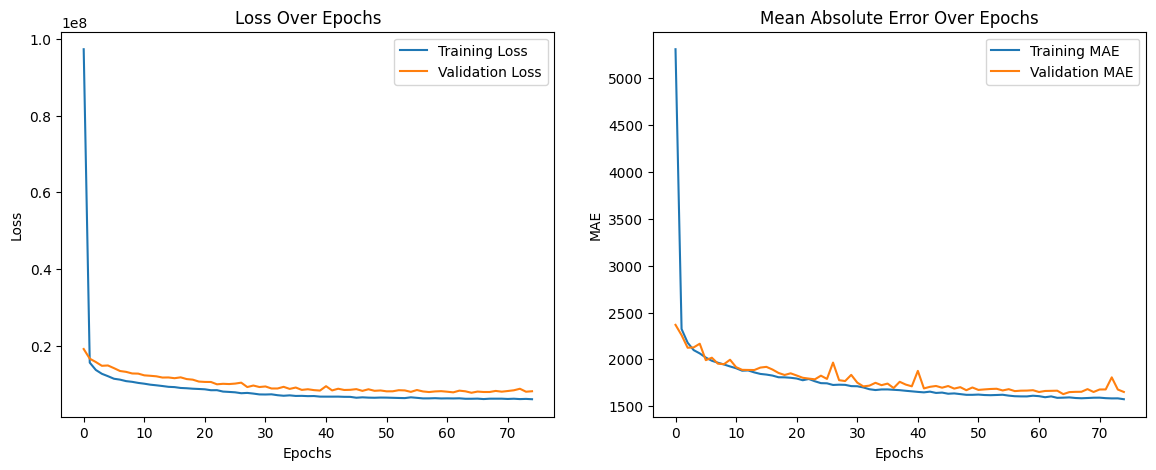

In [16]:
plot_metrics(history)

Let's test the neural network on the testing set.

In [17]:
first_model_predictions = first_model.predict(dataset_test_scaled).flatten()

first_model_mea = mean_absolute_error(prices_test.flatten(), first_model_predictions)
print(f'MEA on test set for the first model: {first_model_mea}')

259/259 [==============================] - 1s 2ms/step
MEA on test set for the first model: 1644.7028551214805


**Result**

The mean absolute error on testing set is about 1645$ on first model of NN.To visualize the performance, we can use a scatter plot.

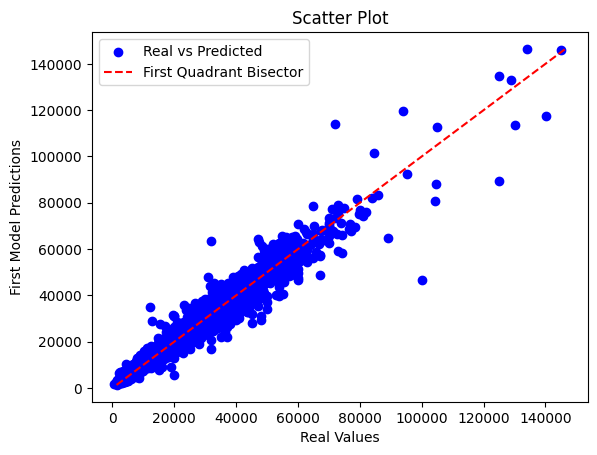

In [18]:
plt.scatter(prices_test, first_model_predictions, color='blue', label='Real vs Predicted')

plt.xlabel('Real Values')
plt.ylabel('First Model Predictions')
plt.title('Scatter Plot')

x_bisector = np.linspace(min(first_model_predictions), max(first_model_predictions), 100)
y_bisector = x_bisector
plt.plot(x_bisector, y_bisector, color='red', linestyle='--', label='First Quadrant Bisector')

plt.legend()

plt.show()

We can see that the predictions oscillate around the bisector, this is a sign of good performance on average of the model.

For completeness, we plot the error of the predicitons.

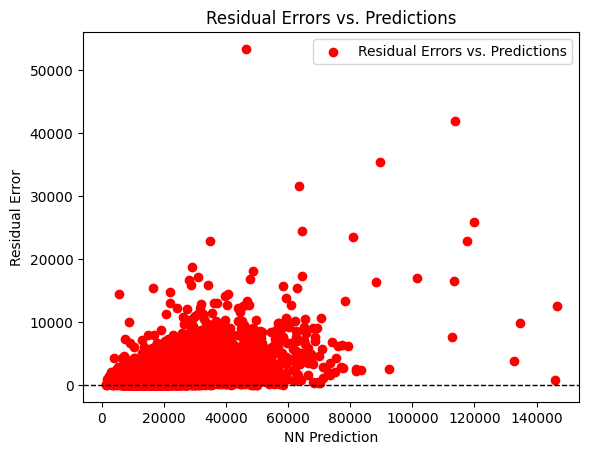

In [19]:
residuals = np.abs(prices_test - first_model_predictions.flatten())
residuals = np.array(residuals)
nn_predictions = np.array(first_model_predictions)

plt.scatter(first_model_predictions, residuals, color = 'red', label = 'Residual Errors vs. Predictions')
plt.axhline(0, color = 'black', linestyle='--', linewidth=1)

plt.xlabel('NN Prediction')
plt.ylabel('Residual Error')
plt.title('Residual Errors vs. Predictions')
plt.legend()

plt.show()

The graph shows that most of the points are well classified although there are some outliers.

Let's count the number of outliers for the first model.

In [35]:
first_model_outliers = count_outliers(prices_test, first_model_predictions.flatten())
print(f'The number of outilers of the First Model are: {first_model_outliers}')

The number of outilers of the First Model are: 65


Now let us consider other metrics for evaluating the considered model:
* **Root Mean Squared Error (RMSE)**:
* **R-squared (R²) or Coefficient of Determination**
* **Explained Variance Score**

In [32]:
#Evaluate Metrics
first_model_rmse = np.sqrt(mean_squared_error(y_true = prices_test, y_pred = first_model_predictions))
first_model_r2 = r2_score(y_true = prices_test, y_pred = first_model_predictions)
first_model_evs = explained_variance_score(y_true = prices_test, y_pred = first_model_predictions)

#Print Results
print(f'Value of Root Mean Squared Error of First Model: {first_model_rmse}')
print(f'Value of R-Squared of First Model: {first_model_r2}')
print(f'Value of Explained Variance Score of First Model: {first_model_evs}')

Value of Root Mean Squared Error of First Model: 2662.7703998594643
Value of R-Squared of First Model: 0.9479874968580102
Value of Explained Variance Score of First Model: 0.9479912389625114


Let us now consider a **second model** neural network.



In [21]:
#Defined number of units per layer
number_of_layers = 4
units_per_layer = [128, 256, 128, 64]

#Defined Learing Rate
learning_rate = 0.01

#Defined Weight Inizializer
initializer = GlorotUniform()

#Create Sequential Model
second_model = Sequential()

second_model.add(Dense(112, activation = 'relu'))

#Add level to model
for units in units_per_layer:
  second_model.add(Dense(units,
                        activation = 'relu',
                        kernel_initializer = initializer))


second_model.add(Dense(1, activation = 'relu'))
optimizer = Adam(learning_rate = learning_rate)
second_model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
second_model.build(input_shape = (None, 111))

In [22]:
second_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 112)               12544     
                                                                 
 dense_6 (Dense)             (None, 128)               14464     
                                                                 
 dense_7 (Dense)             (None, 256)               33024     
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 101249 (395.50 KB)
Trainable params: 101

In [23]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

In [24]:
history = second_model.fit(dataset_training_scaled,
                prices_training,
                epochs = 500,
                batch_size = 32,
                validation_data = (dataset_validation_scaled, prices_validation),
                callbacks = [early_stopping])

Epoch 1/500
827/827 [==============================] - 9s 9ms/step - loss: 36832480.0000 - mean_absolute_error: 3578.1775 - val_loss: 22865864.0000 - val_mean_absolute_error: 2727.4971
Epoch 2/500
827/827 [==============================] - 4s 5ms/step - loss: 18066136.0000 - mean_absolute_error: 2569.3196 - val_loss: 17883594.0000 - val_mean_absolute_error: 2408.5139
Epoch 3/500
827/827 [==============================] - 8s 10ms/step - loss: 16522785.0000 - mean_absolute_error: 2502.4023 - val_loss: 17911006.0000 - val_mean_absolute_error: 2543.9617
Epoch 4/500
827/827 [==============================] - 4s 5ms/step - loss: 15608054.0000 - mean_absolute_error: 2403.6648 - val_loss: 14109296.0000 - val_mean_absolute_error: 2042.9756
Epoch 5/500
827/827 [==============================] - 4s 5ms/step - loss: 14995535.0000 - mean_absolute_error: 2399.7246 - val_loss: 20424262.0000 - val_mean_absolute_error: 2472.1165
Epoch 6/500
827/827 [==============================] - 5s 6ms/step - loss:

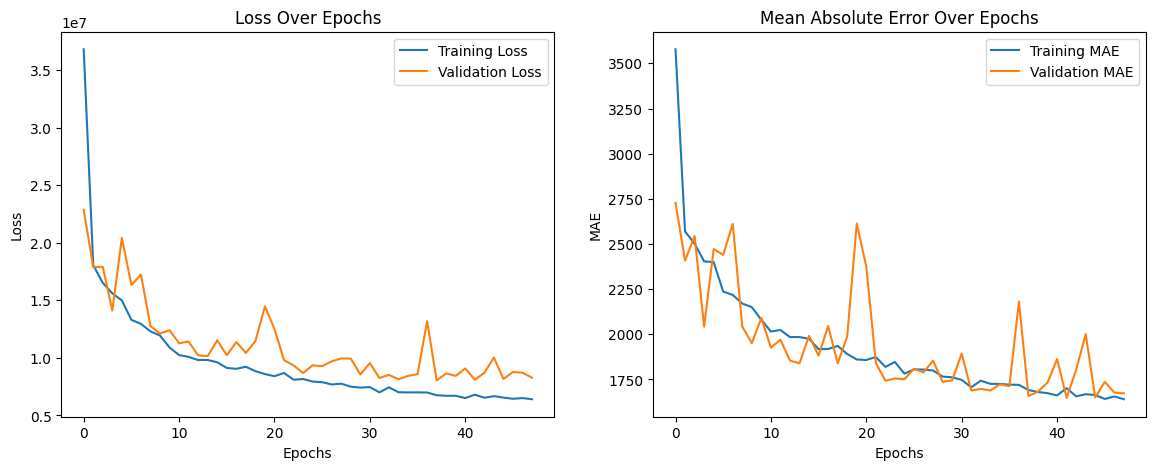

In [25]:
plot_metrics(history)

Let's test the second model on testing set.


In [26]:
second_model_predictions = second_model.predict(dataset_test_scaled).flatten()

second_model_mea = mean_absolute_error(prices_test.flatten(), second_model_predictions)
print(f'MEA on test set for the first model: {second_model_mea}')

259/259 [==============================] - 1s 2ms/step
MEA on test set for the first model: 1675.111984493022


**Result**

The mean absolute error on testing set is about 1675$ on second model of NN.To visualize the performance, we can use a scatter plot.

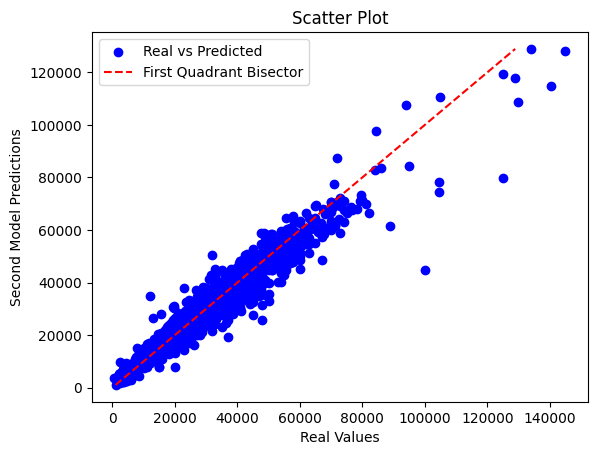

In [47]:
plt.scatter(prices_test, second_model_predictions, color='blue', label='Real vs Predicted')

plt.xlabel('Real Values')
plt.ylabel('Second Model Predictions')
plt.title('Scatter Plot')

x_bisector = np.linspace(min(second_model_predictions), max(second_model_predictions), 100)
y_bisector = x_bisector
plt.plot(x_bisector, y_bisector, color='red', linestyle='--', label='First Quadrant Bisector')

plt.legend()

plt.show()

We can see that the predictions oscillate around the bisector, this is a sign of good performance on average of the model.

For completeness, we plot the error of the predicitons.

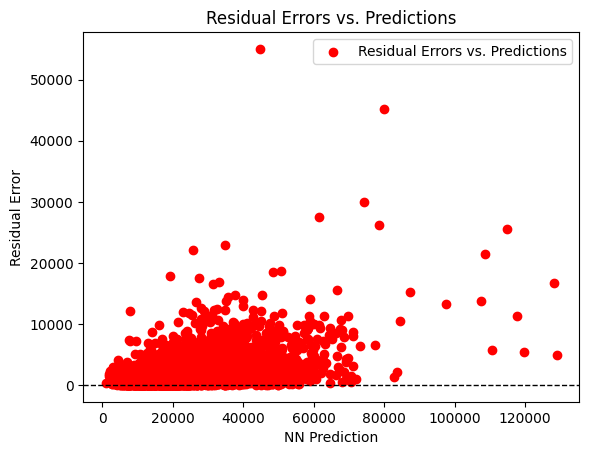

In [28]:
residuals = np.abs(prices_test - second_model_predictions.flatten())
residuals = np.array(residuals)
nn_predictions = np.array(second_model_predictions)

plt.scatter(second_model_predictions, residuals, color = 'red', label = 'Residual Errors vs. Predictions')
plt.axhline(0, color = 'black', linestyle='--', linewidth=1)

plt.xlabel('NN Prediction')
plt.ylabel('Residual Error')
plt.title('Residual Errors vs. Predictions')
plt.legend()

plt.show()

Let's now consider the other metrics to evaluate the performance of the second model.

In [33]:
#Evaluate Metrics
second_model_rmse = np.sqrt(mean_squared_error(y_true = prices_test, y_pred = second_model_predictions))
second_model_r2 = r2_score(y_true = prices_test, y_pred = second_model_predictions)
second_model_evs = explained_variance_score(y_true = prices_test, y_pred = second_model_predictions)

#Print Results
print(f'Value of Root Mean Squared Error of Second Model: {second_model_rmse}')
print(f'Value of R-Squared of Second Model: {second_model_r2}')
print(f'Value of Explained Variance Score of Second Model: {second_model_evs}')

Value of Root Mean Squared Error of Second Model: 2679.815561206762
Value of R-Squared of Second Model: 0.9473194714990529
Value of Explained Variance Score of Second Model: 0.9475678006637186


Let's count the number of outlier of the Second Model.

In [36]:
second_model_outliers = count_outliers(prices_test, second_model_predictions.flatten())
print(f'The number of outilers of the First Model are: {second_model_outliers}')

The number of outilers of the First Model are: 66


As can be seen from the results, the performance of the first two NN models is very similar, but in the second model there are both more units per level and more hidden levels.

Let's now consider a **third model** of NN.

In [39]:
#Defined number of units per layer
number_of_layers = 2
units_per_layer = [256, 128]

#Defined Learing Rate
learning_rate = 0.001

#Defined Weight Inizializer
initializer = RandomNormal(mean = 0, stddev = 1)

#Create Sequential Model
third_model = Sequential()

third_model.add(Dense(112, activation = 'relu'))

#Add level to model
for units in units_per_layer:
  third_model.add(Dense(units,
                        activation = 'relu',
                        kernel_initializer = initializer))


third_model.add(Dense(1, activation = 'relu'))
optimizer = Adam(learning_rate = learning_rate)
third_model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
third_model.build(input_shape = (None, 111))

In [40]:
third_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 112)               12544     
                                                                 
 dense_16 (Dense)            (None, 256)               28928     
                                                                 
 dense_17 (Dense)            (None, 128)               32896     
                                                                 
 dense_18 (Dense)            (None, 1)                 129       
                                                                 
Total params: 74497 (291.00 KB)
Trainable params: 74497 (291.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

In [48]:
history = third_model.fit(dataset_training_scaled,
                prices_training,
                epochs = 300,
                batch_size = 32,
                validation_data = (dataset_validation_scaled, prices_validation),
                callbacks = [early_stopping])

Epoch 1/300
827/827 [==============================] - 3s 3ms/step - loss: 4864877.0000 - mean_absolute_error: 1436.5479 - val_loss: 7725029.5000 - val_mean_absolute_error: 1577.6759
Epoch 2/300
827/827 [==============================] - 3s 3ms/step - loss: 4715037.0000 - mean_absolute_error: 1420.1757 - val_loss: 7273445.5000 - val_mean_absolute_error: 1550.1444
Epoch 3/300
827/827 [==============================] - 3s 4ms/step - loss: 4745926.0000 - mean_absolute_error: 1418.9087 - val_loss: 7309709.5000 - val_mean_absolute_error: 1550.5737
Epoch 4/300
827/827 [==============================] - 4s 5ms/step - loss: 4789663.0000 - mean_absolute_error: 1426.5435 - val_loss: 7460100.0000 - val_mean_absolute_error: 1587.4302
Epoch 5/300
827/827 [==============================] - 3s 3ms/step - loss: 4734796.5000 - mean_absolute_error: 1423.0540 - val_loss: 7415659.0000 - val_mean_absolute_error: 1564.8466
Epoch 6/300
827/827 [==============================] - 3s 3ms/step - loss: 4774578.50

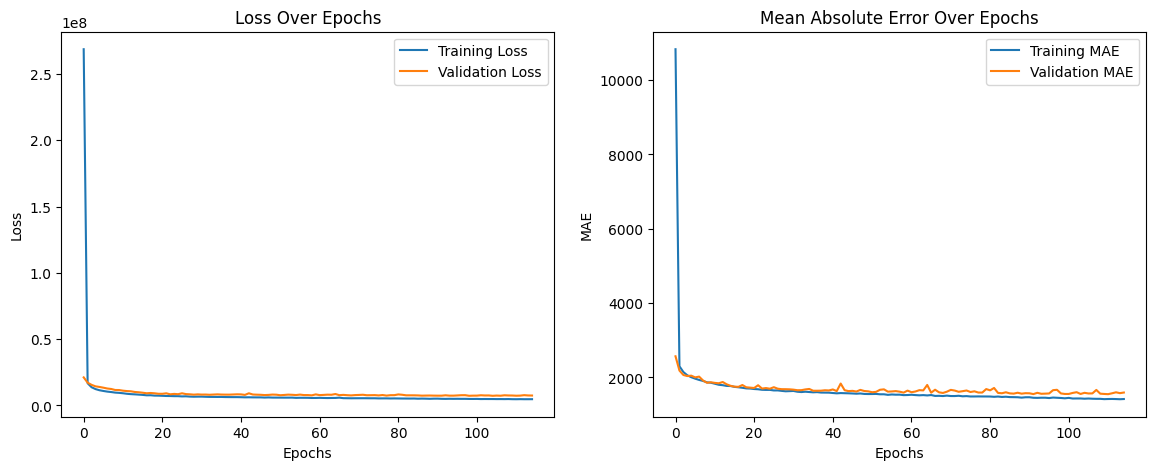

In [44]:
plot_metrics(history)

Let's test the third model on testing set.

In [49]:
third_model_predictions = third_model.predict(dataset_test_scaled).flatten()

third_model_mea = mean_absolute_error(prices_test.flatten(), third_model_predictions)
print(f'MEA on test set for the first model: {third_model_mea}')

259/259 [==============================] - 1s 2ms/step
MEA on test set for the first model: 1565.0125275212263


**Result**

The mean absolute error on testing set is about 1565$ on third model of NN.To visualize the performance, we can use a scatter plot.

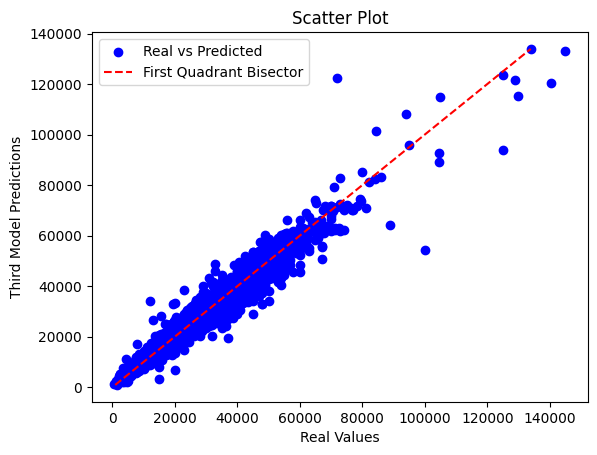

In [50]:
plt.scatter(prices_test, third_model_predictions, color='blue', label='Real vs Predicted')

plt.xlabel('Real Values')
plt.ylabel('Third Model Predictions')
plt.title('Scatter Plot')

x_bisector = np.linspace(min(third_model_predictions), max(third_model_predictions), 100)
y_bisector = x_bisector
plt.plot(x_bisector, y_bisector, color='red', linestyle='--', label='First Quadrant Bisector')

plt.legend()

plt.show()

We can see that the predictions oscillate around the bisector, this is a sign of good performance on average of the model.

For completeness, we plot the error of the predicitons.

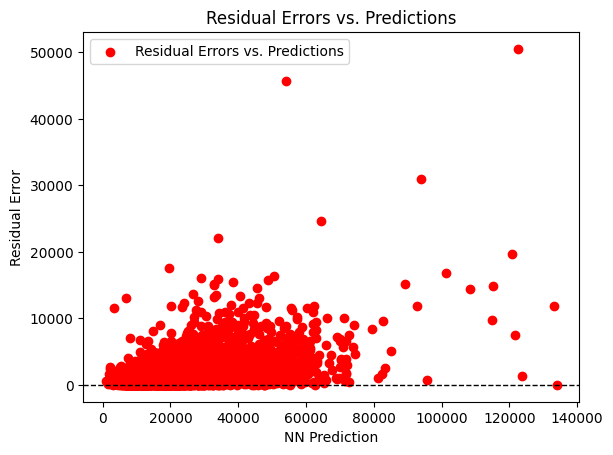

In [51]:
residuals = np.abs(prices_test - third_model_predictions.flatten())
residuals = np.array(residuals)
nn_predictions = np.array(third_model_predictions)

plt.scatter(third_model_predictions, residuals, color = 'red', label = 'Residual Errors vs. Predictions')
plt.axhline(0, color = 'black', linestyle='--', linewidth=1)

plt.xlabel('NN Prediction')
plt.ylabel('Residual Error')
plt.title('Residual Errors vs. Predictions')
plt.legend()

plt.show()

Let's now consider the other metrics to evaluate the performance of the third model.

In [67]:
#Evaluate Metrics
third_model_rmse = np.sqrt(mean_squared_error(y_true = prices_test, y_pred = third_model_predictions))
third_model_r2 = r2_score(y_true = prices_test, y_pred = third_model_predictions)
third_model_evs = explained_variance_score(y_true = prices_test, y_pred = third_model_predictions)

#Print Results
print(f'Value of Root Mean Squared Error of Third Model: {third_model_rmse}')
print(f'Value of R-Squared of Third Model: {third_model_r2}')
print(f'Value of Explained Variance Score of Third Model: {third_model_evs}')

Value of Root Mean Squared Error of Third Model: 2483.387729988356
Value of R-Squared of Third Model: 0.9547592937618934
Value of Explained Variance Score of Third Model: 0.9550243473667455


Let's count the number of outlier of the Third Model.

In [53]:
third_model_outliers = count_outliers(prices_test, third_model_predictions.flatten())
print(f'The number of outilers of the Third Model are: {third_model_outliers}')

The number of outilers of the Third Model are: 56


The third model has, for now, the best values for the considered metrics and has the fewest number of outliers.

Let's cosider the last model of NN.

In [55]:
#Defined number of units per layer
number_of_layers = 5
units_per_layer = [10, 55, 45, 55, 100]

#Defined Learing Rate
learning_rate = 0.01

#Defined Weight Inizializer
initializer = GlorotNormal()

#Create Sequential Model
fourth_model = Sequential()

fourth_model.add(Dense(112, activation = 'relu'))

#Add level to model
for units in units_per_layer:
  fourth_model.add(Dense(units,
                        activation = 'relu',
                        kernel_initializer = initializer))


fourth_model.add(Dense(1, activation = 'relu'))
optimizer = Adam(learning_rate = learning_rate)
fourth_model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
fourth_model.build(input_shape = (None, 111))

In [56]:
fourth_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 112)               12544     
                                                                 
 dense_20 (Dense)            (None, 10)                1130      
                                                                 
 dense_21 (Dense)            (None, 55)                605       
                                                                 
 dense_22 (Dense)            (None, 45)                2520      
                                                                 
 dense_23 (Dense)            (None, 55)                2530      
                                                                 
 dense_24 (Dense)            (None, 100)               5600      
                                                                 
 dense_25 (Dense)            (None, 1)                

In [57]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

In [61]:
history = fourth_model.fit(dataset_training_scaled,
                prices_training,
                epochs = 350,
                batch_size = 32,
                validation_data = (dataset_validation_scaled, prices_validation),
                callbacks = [early_stopping])

Epoch 1/350
827/827 [==============================] - 3s 3ms/step - loss: 8649982.0000 - mean_absolute_error: 1877.1938 - val_loss: 9825152.0000 - val_mean_absolute_error: 1816.0177
Epoch 2/350
827/827 [==============================] - 4s 5ms/step - loss: 8319483.5000 - mean_absolute_error: 1832.8079 - val_loss: 12117762.0000 - val_mean_absolute_error: 2007.3839
Epoch 3/350
827/827 [==============================] - 3s 4ms/step - loss: 8299524.5000 - mean_absolute_error: 1839.5825 - val_loss: 10705569.0000 - val_mean_absolute_error: 1853.3599
Epoch 4/350
827/827 [==============================] - 3s 3ms/step - loss: 8191066.0000 - mean_absolute_error: 1836.6124 - val_loss: 12661941.0000 - val_mean_absolute_error: 2049.8337
Epoch 5/350
827/827 [==============================] - 3s 3ms/step - loss: 8099424.0000 - mean_absolute_error: 1821.5271 - val_loss: 10137578.0000 - val_mean_absolute_error: 1913.6659
Epoch 6/350
827/827 [==============================] - 3s 3ms/step - loss: 836377

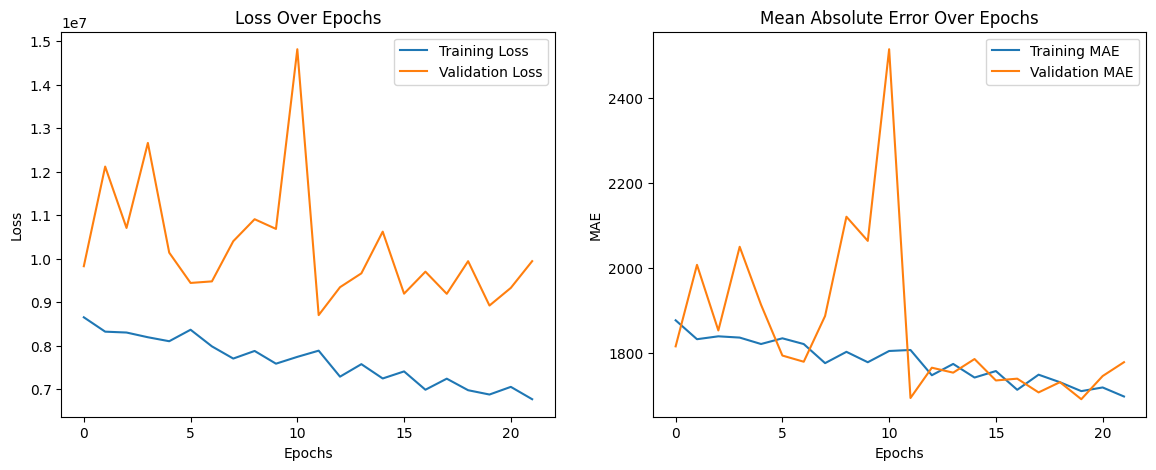

In [62]:
plot_metrics(history)

Let's test the fourth model on testing set.

In [63]:
fourth_model_predictions = fourth_model.predict(dataset_test_scaled).flatten()

fourth_model_mea = mean_absolute_error(prices_test.flatten(), fourth_model_predictions)
print(f'MEA on test set for the first model: {fourth_model_mea}')

259/259 [==============================] - 0s 1ms/step
MEA on test set for the first model: 1716.703773175334


**Result**

The mean absolute error on testing set is about 1717$ on fourth model of NN.To visualize the performance, we can use a scatter plot.

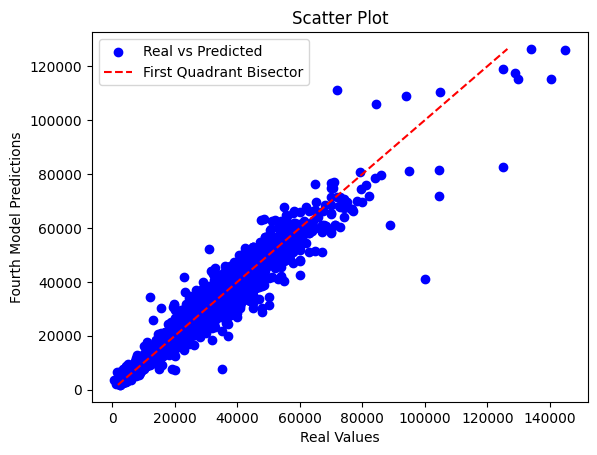

In [64]:
plt.scatter(prices_test, fourth_model_predictions, color='blue', label='Real vs Predicted')

plt.xlabel('Real Values')
plt.ylabel('Fourth Model Predictions')
plt.title('Scatter Plot')

x_bisector = np.linspace(min(fourth_model_predictions), max(fourth_model_predictions), 100)
y_bisector = x_bisector
plt.plot(x_bisector, y_bisector, color='red', linestyle='--', label='First Quadrant Bisector')

plt.legend()

plt.show()

We can see that the predictions oscillate around the bisector, this is a sign of good performance on average of the model.

For completeness, we plot the error of the predicitons.

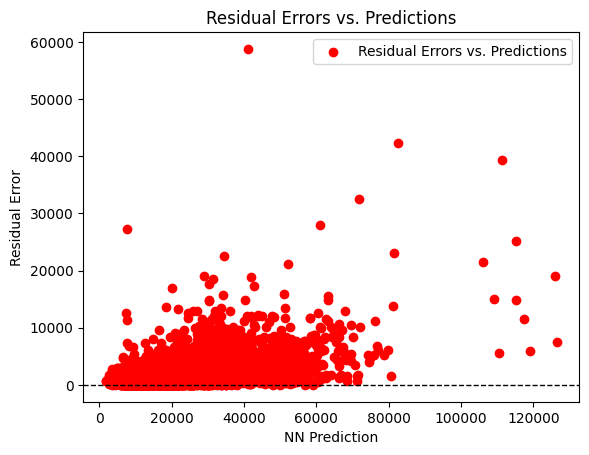

In [65]:
residuals = np.abs(prices_test - fourth_model_predictions.flatten())
residuals = np.array(residuals)
nn_predictions = np.array(fourth_model_predictions)

plt.scatter(fourth_model_predictions, residuals, color = 'red', label = 'Residual Errors vs. Predictions')
plt.axhline(0, color = 'black', linestyle='--', linewidth=1)

plt.xlabel('NN Prediction')
plt.ylabel('Residual Error')
plt.title('Residual Errors vs. Predictions')
plt.legend()

plt.show()

Let's now consider the other metrics to evaluate the performance of the fourth model.

In [66]:
#Evaluate Metrics
fourth_model_rmse = np.sqrt(mean_squared_error(y_true = prices_test, y_pred = fourth_model_predictions))
fourth_model_r2 = r2_score(y_true = prices_test, y_pred = fourth_model_predictions)
fourth_model_evs = explained_variance_score(y_true = prices_test, y_pred = fourth_model_predictions)

#Print Results
print(f'Value of Root Mean Squared Error of Fourth Model: {third_model_rmse}')
print(f'Value of R-Squared of Fourth Model: {third_model_r2}')
print(f'Value of Explained Variance Score of Fourth Model: {fourth_model_evs}')

Value of Root Mean Squared Error of Fourth Model: 2483.387729988356
Value of R-Squared of Fourth Model: 0.9547592937618934
Value of Explained Variance Score of Fourth Model: 0.9425267953825847


Let's count the number of outlier of the Fourth Model.

In [68]:
fourth_model_outliers = count_outliers(prices_test, fourth_model_predictions.flatten())
print(f'The number of outilers of the Fourth Model are: {fourth_model_outliers}')

The number of outilers of the Fourth Model are: 83


As can be seen from the value of the metrics considered and the number of outliers, this last NN model is the worst model analyzed so far.

##**Random Forest**##

Now, we are going to try a random forest model, in order to compare it with the previous NNs based model.\
For the hyperparameters tuning, we're using RandomizedSearchCV.

In [ ]:
random_forest_model = RandomForestRegressor()

param_dist = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}

random_search = RandomizedSearchCV(
    random_forest_model,
    param_distributions = param_dist,
    n_iter = 300,
    scoring = 'neg_mean_absolute_error',
    cv = 5,
    verbose = 1,
    n_jobs = -1
)

random_search.fit(dataset_training_scaled, prices_training)

print("Best hyperparameters:", random_search.best_params_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
